# References

In [1]:
# References

# week11 - Demo_async (functional vs sequential API)
# week06 - FFNN_DiabeticRetinopathy (building a FFNN)
# week05 - imbalanced_data (standardization)
# week03 - linear_regression (keras linear regression model)

# Import packages and data

In [1]:
# Standard
import pandas as pd
import numpy as np
import random
import os
import math

# TF and Keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import models
from keras import layers
from keras import metrics
from keras import losses
from keras import regularizers

# Plots and images
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image
%matplotlib inline

# Silence TF
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Setting random seeds
random.seed(0)
np.random.seed(0)
tf.random.set_seed(0)

2023-12-04 22:29:35.140608: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Google Data Import
Run to access your drive from google colab

from google.colab import drive
drive.mount('/content/drive', force_remount=False)

X_train = pd.read_csv('drive/MyDrive/data/X_train.csv')
Y_train = pd.read_csv('drive/MyDrive/data/Y_train.csv')
X_val = pd.read_csv('drive/MyDrive/data/X_val.csv')
Y_val = pd.read_csv('drive/MyDrive/data/Y_val.csv')

## Local Data Import

In [2]:
X_train = pd.read_csv('X_train.csv')
Y_train = pd.read_csv('Y_train.csv')
X_val = pd.read_csv('X_val.csv')
Y_val = pd.read_csv('Y_val.csv')

In [3]:
X_train.drop(columns=['Unnamed: 0'], inplace=True)
Y_train.drop(columns=['Unnamed: 0'], inplace=True)
X_val.drop(columns=['Unnamed: 0'], inplace=True)
Y_val.drop(columns=['Unnamed: 0'], inplace=True)

## Making One-Hot Encodings and Tensors for Categorical Variables

In [4]:
# Data prep

# Merging train and val into one DF to perform the encodings
X = pd.concat([X_train, X_val])

# Making the numerical categorical variables into strings - necessary to make the one-hot encodings
X[['opp_diff_ind', 'GW','was_home']] = X[['opp_diff_ind', 'GW','was_home']].astype(str)

In [5]:
# Making categorical variables into sparse one-hot encodings

season_tf = tf.keras.layers.StringLookup(vocabulary=X.season.unique(), output_mode='one_hot')(X.season)

player_team_name_tf = tf.keras.layers.StringLookup(vocabulary=X.player_team_name.unique(), 
                                                         output_mode='one_hot')(X.player_team_name)

opp_team_name_tf = tf.keras.layers.StringLookup(vocabulary=X.opp_team_name.unique(), 
                                                      output_mode='one_hot')(X.opp_team_name)

opp_diff_ind_tf = tf.keras.layers.StringLookup(vocabulary=X.opp_diff_ind.unique(), 
                                                      output_mode='one_hot')(X.opp_diff_ind)

position_tf = tf.keras.layers.StringLookup(vocabulary=X.position.unique(), output_mode='one_hot')(X.position)

gw_tf = tf.keras.layers.StringLookup(vocabulary=X.GW.unique(), output_mode='one_hot')(X.GW)

was_home_tf = tf.keras.layers.StringLookup(vocabulary=X.was_home.unique(), output_mode='one_hot')(X.was_home)

In [6]:
# Making a tensor with the split sizes
split_one = X_train.shape[0]
split_two = X_val.shape[0]

# Splitting the encoded tensors into train and test
season_train, season_val = tf.split(season_tf, [split_one, split_two], 0)

player_team_name_train, player_team_name_val = tf.split(player_team_name_tf, [split_one, split_two], 0)

opp_team_name_train, opp_team_name_val = tf.split(opp_team_name_tf, [split_one, split_two], 0)

opp_diff_ind_train, opp_diff_ind_val = tf.split(opp_diff_ind_tf, [split_one, split_two], 0)

position_train, position_val = tf.split(position_tf, [split_one, split_two], 0)

gw_train, gw_val = tf.split(gw_tf, [split_one, split_two], 0)

was_home_train, was_home_val = tf.split(was_home_tf, [split_one, split_two], 0)

In [7]:
# Making lists of train and test categorical tensors to combine

train_cat_tf = [season_train, player_team_name_train, opp_team_name_train, opp_diff_ind_train, 
                position_train, gw_train, was_home_train]

val_cat_tf = [season_val, player_team_name_val, opp_team_name_val, opp_diff_ind_val, 
              position_val, gw_val, was_home_val]

## Prepping tensors for continuous variables

In [8]:
# Preparing column combination possibilities
all_cols = X_train.columns

lag_1 = ['assists_lag_1', 'bonus_lag_1', 'bps_lag_1', 'clean_sheets_lag_1',
       'creativity_lag_1', 'goals_conceded_lag_1', 'goals_scored_lag_1',
       'ict_index_lag_1', 'influence_lag_1', 'minutes_lag_1',
       'own_goals_lag_1', 'penalties_missed_lag_1', 'penalties_saved_lag_1',
       'red_cards_lag_1', 'saves_lag_1', 'selected_lag_1',
       'player_team_score_lag_1', 'opp_team_score_lag_1', 'threat_lag_1',
       'total_points_lag_1', 'value_lag_1', 'yellow_cards_lag_1']

lag_3 = ['assists_lag_3', 'bonus_lag_3', 'bps_lag_3', 'clean_sheets_lag_3',
       'creativity_lag_3', 'goals_conceded_lag_3', 'goals_scored_lag_3',
       'ict_index_lag_3', 'influence_lag_3', 'minutes_lag_3',
       'own_goals_lag_3', 'penalties_missed_lag_3', 'penalties_saved_lag_3',
       'red_cards_lag_3', 'saves_lag_3', 'selected_lag_3',
       'player_team_score_lag_3', 'opp_team_score_lag_3', 'threat_lag_3',
       'total_points_lag_3', 'value_lag_3', 'yellow_cards_lag_3']

lag_5 = ['assists_lag_5', 'bonus_lag_5', 'bps_lag_5', 'clean_sheets_lag_5',
       'creativity_lag_5', 'goals_conceded_lag_5', 'goals_scored_lag_5',
       'ict_index_lag_5', 'influence_lag_5', 'minutes_lag_5',
       'own_goals_lag_5', 'penalties_missed_lag_5', 'penalties_saved_lag_5',
       'red_cards_lag_5', 'saves_lag_5', 'selected_lag_5',
       'player_team_score_lag_5', 'opp_team_score_lag_5', 'threat_lag_5',
       'total_points_lag_5', 'value_lag_5', 'yellow_cards_lag_5']

In [9]:
# Making continuous variable tensors
X_train_contin1_tf = tf.convert_to_tensor(X_train[lag_1])
X_train_contin3_tf = tf.convert_to_tensor(X_train[lag_3])
X_train_contin5_tf = tf.convert_to_tensor(X_train[lag_5])

X_val_contin1_tf = tf.convert_to_tensor(X_val[lag_1])
X_val_contin3_tf = tf.convert_to_tensor(X_val[lag_3])
X_val_contin5_tf = tf.convert_to_tensor(X_val[lag_5])

In [10]:
# Making label tensors
Y_train_tf = tf.convert_to_tensor(Y_train)
Y_val_tf = tf.convert_to_tensor(Y_val)

# Making a linear regression model

In [11]:
# Specifying the inputs

epoch_count = 20

# Preparing the train and val tensors. I'll be using all the categorical variables and the lag 3 continuous variables for now
train_list = [season_train, player_team_name_train, opp_team_name_train, opp_diff_ind_train, 
                position_train, gw_train, was_home_train, X_train_contin3_tf]

val_list = [season_val, player_team_name_val, opp_team_name_val, opp_diff_ind_val, 
              position_val, gw_val, was_home_val, X_val_contin3_tf]

X_train_input = tf.keras.layers.Concatenate(axis=1)(train_list)
X_val_input = tf.keras.layers.Concatenate(axis=1)(val_list)

num_features = X_train_input.shape[1]

In [12]:
# Building and compiling the model
tf.keras.backend.clear_session()
model = tf.keras.Sequential()

# Create input layer
model.add(tf.keras.Input(shape=(num_features,), name='Input'
          ))

# Create output layer
model.add(tf.keras.layers.Dense(
          activation = None,    # linear activation is used
          units = 1,            # output dim - need to make sure this is correct
          use_bias = True             
          ))

# Select optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

# Compile the model
model.compile(
    optimizer=optimizer,
    loss=losses.MeanSquaredError(),
    metrics=[metrics.mse,
             metrics.RootMeanSquaredError(),
             metrics.mae]
    )

In [13]:
# Fitting the model
history = model.fit(
    x = X_train_input,
    y = Y_train_tf,
    epochs = epoch_count,
    validation_data = (X_val_input, Y_val_tf)
    )

Epoch 1/20
2150/2150 [==============================] - 2s 707us/step - loss: 4.9049 - mean_squared_error: 4.9049 - root_mean_squared_error: 2.2147 - mean_absolute_error: 1.2747 - val_loss: 4.5403 - val_mean_squared_error: 4.5403 - val_root_mean_squared_error: 2.1308 - val_mean_absolute_error: 1.1311
Epoch 2/20
2150/2150 [==============================] - 1s 671us/step - loss: 4.6630 - mean_squared_error: 4.6630 - root_mean_squared_error: 2.1594 - mean_absolute_error: 1.2665 - val_loss: 4.5375 - val_mean_squared_error: 4.5375 - val_root_mean_squared_error: 2.1301 - val_mean_absolute_error: 1.1136
Epoch 3/20
2150/2150 [==============================] - 1s 661us/step - loss: 4.6424 - mean_squared_error: 4.6424 - root_mean_squared_error: 2.1546 - mean_absolute_error: 1.2604 - val_loss: 4.5175 - val_mean_squared_error: 4.5175 - val_root_mean_squared_error: 2.1255 - val_mean_absolute_error: 1.1227
Epoch 4/20
2150/2150 [==============================] - 1s 659us/step - loss: 4.6332 - mean_sq

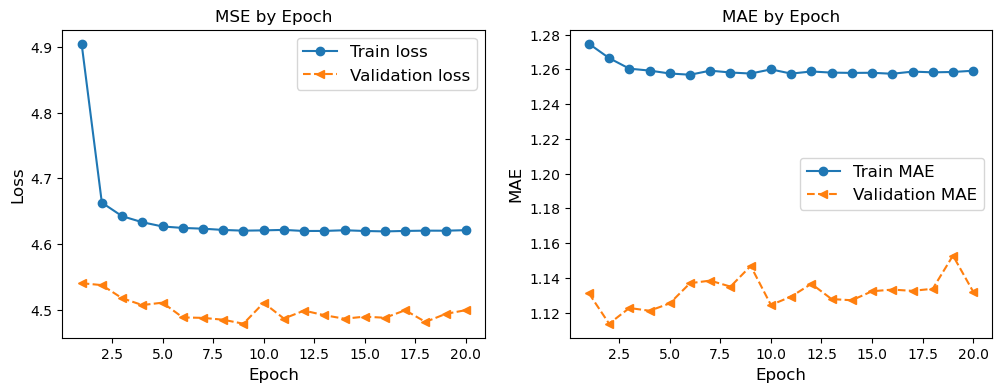

In [14]:
# Plotting loss and accuracy for training and validation sets
hist = history.history
x_arr = np.arange(len(hist['loss'])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist['loss'], '-o', label='Train loss')
ax.plot(x_arr, hist['val_loss'], '--<', label='Validation loss')
ax.legend(fontsize=12)
ax.set_xlabel('Epoch', size=12)
ax.set_ylabel('Loss', size=12)
ax.set_title('MSE by Epoch')

ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist['mean_absolute_error'], '-o', label='Train MAE')
ax.plot(x_arr, hist['val_mean_absolute_error'], '--<', label='Validation MAE')
ax.legend(fontsize=12)
ax.set_xlabel('Epoch', size=12)
ax.set_ylabel('MAE', size=12)
ax.set_title('MAE by Epoch')

pass

# Making a Baseline

In [15]:
# Setting up necessary functions

# Making a vector of predictions as long as the actuals
def pred_vect(true_values, prediction=2):
    predictions = []
    count = 0
    pred = prediction # Can pass baseline or 2
    while count < len(true_values):
        predictions.append(pred)
        count += 1
        
    return predictions

# Defining an MSE function
def MSE(true_values, predicted_values):
    """Return the MSE between true_values and predicted values."""
    tot = 0
    count = 0
    
    # Calculating the SE for each data point
    while count < len(true_values):
        tot += (true_values[count] - predicted_values[count])**2
        count += 1
    
    # Returning the MSE
    return tot / len(true_values)

def RMSE(true_values, predicted_values):
    """Return the RMSE between true_values and predicted values."""
    tot = 0
    count = 0
    
    # Calculating the SE for each data point
    while count < len(true_values):
        tot += (true_values[count] - predicted_values[count])**2
        count += 1
    
    # Returning the MSE
    return math.sqrt(tot / len(true_values))

def MAE(true_values, predicted_values):
    """Return the MAE between true_values and predicted values."""
    tot = 0
    count = 0
    
    # Calculating the SE for each data point
    while count < len(true_values):
        tot += abs(true_values[count] - predicted_values[count])
        count += 1
    
    # Returning the MSE
    return tot / len(true_values)

In [16]:
# Creating a baseline with the average value
baseline = Y_train['total_points'].mean()
baseline

1.3593784070590629

In [17]:
true = np.array(Y_train['total_points'])
pred = np.array(pred_vect(Y_train['total_points'],1))

#print(f'RMSE is {round(RMSE(true, pred),3)}')
print(f'MSE is {round(MSE(true, pred),3)}')
print(f'MAE is {round(MAE(true, pred),3)}')

MSE is 6.432
MAE is 1.508


# Making a FFNN

In [18]:
def loss_mae_plots(history):
    '''
    Takes in history from model fitting and plots loss and MAE by epoch for both train and val
    '''
    hist = history.history
    x_arr = np.arange(len(hist['loss'])) + 1
    
    fig = plt.figure(figsize=(12, 4))
    ax = fig.add_subplot(1, 2, 1)
    ax.plot(x_arr, hist['loss'], '-o', label='Train loss')
    ax.plot(x_arr, hist['val_loss'], '--<', label='Validation loss')
    ax.legend(fontsize=12)
    ax.set_xlabel('Epoch', size=12)
    ax.set_ylabel('Loss', size=12)
    ax.set_title('Loss by Epoch')

    ax = fig.add_subplot(1, 2, 2)
    ax.plot(x_arr, hist['mean_absolute_error'], '-o', label='Train MAE')
    ax.plot(x_arr, hist['val_mean_absolute_error'], '--<', label='Validation MAE')
    ax.legend(fontsize=12)
    ax.set_xlabel('Epoch', size=12)
    ax.set_ylabel('MAE', size=12)
    ax.set_title('MAE by Epoch')

In [19]:
# Making a DF in which to store results
results = pd.DataFrame(columns=['contin_vars', 'lagged_vars', 'learning_rate', 'epoch_count', 'hidden_layer_count',
                                'hidden_layer_size_s','hl_act_func','dropout_rate','oput_act_func','optimizer',
                                'train_loss', 'train_mae','val_loss','val_mae'])

In [20]:
# Setup for testing different configurations

def create_nn(contin_vars='yes', lagged_vars=3, learning_rate=0.01, epoch_count=5, hidden_layer_sizes=[], 
              hl_act_func='relu', dropout_rate=0.3, oput_act_func=None, optimizer='Adam', plot_flag=True,
              verbosity_flag=True):
    
    ############################################################################################## 1
    # Preparing the data

    # Note: the user must at least either feed in 'yes' to contin_vars or 1, 3, or 5 to lagged_vars to avoid errors;
    # if a user passed 'no' and another number, the code will error out
    
    # Runs if user wants to include continuous variables
    if contin_vars == 'yes':
        train_list = train_cat_tf
        val_list = val_cat_tf

        if lagged_vars == 1:
            train_list = [season_train, player_team_name_train, opp_team_name_train, opp_diff_ind_train, 
                          position_train, gw_train, was_home_train, X_train_contin1_tf]
            val_list = [season_val, player_team_name_val, opp_team_name_val, opp_diff_ind_val, 
                        position_val, gw_val, was_home_val, X_val_contin1_tf]
        elif lagged_vars == 3:
            train_list = [season_train, player_team_name_train, opp_team_name_train, opp_diff_ind_train, 
                          position_train, gw_train, was_home_train, X_train_contin3_tf]
            val_list = [season_val, player_team_name_val, opp_team_name_val, opp_diff_ind_val, 
                        position_val, gw_val, was_home_val, X_val_contin3_tf]
        elif lagged_vars == 5:
            train_list = [season_train, player_team_name_train, opp_team_name_train, opp_diff_ind_train, 
                          position_train, gw_train, was_home_train, X_train_contin5_tf]
            val_list = [season_val, player_team_name_val, opp_team_name_val, opp_diff_ind_val, 
                        position_val, gw_val, was_home_val, X_val_contin5_tf]
        else:
            pass # Should do nothing
    
        X_train_input = tf.keras.layers.Concatenate(axis=1)(train_list)
        X_val_input = tf.keras.layers.Concatenate(axis=1)(val_list)

    # Runs if user does not want to include continuous variables
    elif contin_vars == 'no':
        if lagged_vars == 1:
            X_train_input = X_train_contin1_tf
            X_val_input = X_val_contin1_tf
        elif lagged_vars == 3:
            X_train_input = X_train_contin3_tf
            X_val_input = X_val_contin3_tf
        elif lagged_vars == 5:
            X_train_input = X_train_contin5_tf
            X_val_input = X_val_contin5_tf
        else:
            raise 'Unsupported lagged_var input: %s' %lagged_vars
    
    # Getting number of features
    num_features = X_train_input.shape[1]

    ############################################################################################## 2
    # Building the model
    tf.keras.backend.clear_session()
    model = tf.keras.Sequential()

    # Create input layer
    model.add(tf.keras.Input(shape=(num_features,), name='Input'
              ))

    # (Optional) Create hidden layers
    for i, hidden_layer_size in enumerate(hidden_layer_sizes):
      model.add(tf.keras.layers.Dense(units=hidden_layer_size,
                                     activation=hl_act_func,
                                     name = f'Hidden_{i+1}'))

    # (Optional) Create dropout
    model.add(tf.keras.layers.Dropout(rate=dropout_rate, name='Dropout') # Need to make dropout rate variable
              )
    
    # Create output layer
    model.add(tf.keras.layers.Dense(
              activation = oput_act_func,    # linear activation is used
              units = 1,                # output dim - need to make sure this is correct
              use_bias = True             
              ))
    
    # Select optimizer
    if optimizer == 'SGD':
      opt = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    elif optimizer == 'Adam':
      opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    else:
      raise 'Unsupported optimizer: %s' %optimizer

    ############################################################################################## 3
    # Compiling the model
    model.compile(
        optimizer=opt,
        loss='mse',
        metrics=[metrics.mse,
                 metrics.RootMeanSquaredError(),
                 metrics.mae]
        )

    ############################################################################################## 4
    # Fitting the model
    history = model.fit(
        x = X_train_input,
        y = Y_train_tf,
        epochs = epoch_count,
        validation_data = (X_val_input, Y_val_tf),
        verbose=verbosity_flag
    )

    ############################################################################################## 5
    # Displaying learning rates
    if plot_flag == True:
        loss_mae_plots(history)

    ############################################################################################## 6
    # Appending results to the results DF

    # Pulling this in to get loss and accuracy
    hist = history.history
    
    new_row = {'contin_vars': contin_vars, 'lagged_vars': lagged_vars, 'learning_rate': learning_rate, 
               'epoch_count': epoch_count, 'hidden_layer_count': len(hidden_layer_sizes), 'hidden_layer_size_s': hidden_layer_sizes,
               'hl_act_func': hl_act_func, 'dropout_rate':dropout_rate, 'oput_act_func': oput_act_func,'optimizer': optimizer, 
               'train_loss': hist['loss'][-1], 'train_mae': hist['mean_absolute_error'][-1], 'val_loss': hist['val_loss'][-1], 
               'val_mae': hist['val_mean_absolute_error'][-1]}
    
    results.loc[len(results)] = new_row

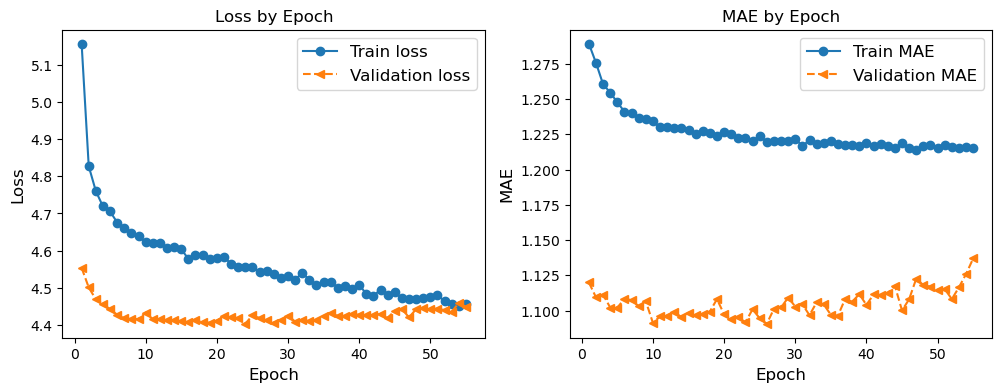

In [21]:
create_nn(contin_vars='yes', lagged_vars=3, epoch_count=55, learning_rate=0.0001, hidden_layer_sizes=[50], verbosity_flag=False)

In [22]:
results

,contin_vars,lagged_vars,learning_rate,epoch_count,hidden_layer_count,hidden_layer_size_s,hl_act_func,dropout_rate,oput_act_func,optimizer,train_loss,train_mae,val_loss,val_mae
0,yes,3,0.0001,55,1,[50],relu,0.3,None,Adam,4.454614,1.215235,4.448567,1.137007


## Testing multiple NN builds

In [54]:
# Testing various NN configurations

for contin_vars in ['yes', 'no']: # Determines whether or not continuous variables are included
    for lagged_vars in [3]: # Determines which lagging (if any) to use - just using 3 for now
        for rate in [0.0001, 0.001]: # Learning rate(s)
            for count in [10, 20]: # Epoch count
                for hl in [[], [37],[50]]: # Hidden layer size(s) - should be a list of list(s)
                    for act_func in ['tanh','relu']: # Activation function - for both hidden layers and output layer (for now)
                        for opt in ['Adam','SGD']: # Optimizer
                            create_nn(contin_vars=contin_vars, lagged_vars=lagged_vars, learning_rate=rate, epoch_count=count, 
                                      hidden_layer_sizes=hl, hl_act_func=act_func, oput_act_func=act_func, optimizer=opt, 
                                      plot_flag=False, verbosity_flag=False)

In [55]:
# Exporting results to CSV
results.to_csv('12_2_v2_results.csv', encoding='utf-8')

In [ ]:
# Number and size of hidden layers

# Between 73 and 1
# Less than twice the size of the input layer
# 2/3 (73) + 1 = 50
# Mean of input and output layers - 37

In [56]:
# Displaying and sorting through results
results.sort_values(by='train_loss',ascending=True)

,contin_vars,lagged_vars,learning_rate,epoch_count,hidden_layer_count,hidden_layer_size_s,hl_act_func,oput_act_func,optimizer,train_loss,train_mae,val_loss,val_mae
46,yes,3,0.0010,20,1,[50],relu,relu,Adam,4.301969,1.123700,4.549056,1.062028
42,yes,3,0.0010,20,1,[37],relu,relu,Adam,4.397158,1.135906,4.482254,1.056553
34,yes,3,0.0010,10,1,[50],relu,relu,Adam,4.467166,1.160152,4.458365,1.041922
30,yes,3,0.0010,10,1,[37],relu,relu,Adam,4.493483,1.165738,4.445357,1.032241
22,yes,3,0.0001,20,1,[50],relu,relu,Adam,4.563469,1.194293,4.386528,1.109876
...,...,...,...,...,...,...,...,...,...,...,...,...,...
48,no,3,0.0001,10,0,[],tanh,tanh,Adam,6.252242,1.267404,5.801263,1.191095
13,yes,3,0.0001,20,0,[],tanh,tanh,SGD,6.255208,1.307607,5.821039,1.125132
1,yes,3,0.0001,10,0,[],tanh,tanh,SGD,6.268654,1.303424,5.808955,1.154204
53,no,3,0.0001,10,1,[37],tanh,tanh,SGD,6.272772,1.284429,5.794054,1.191410


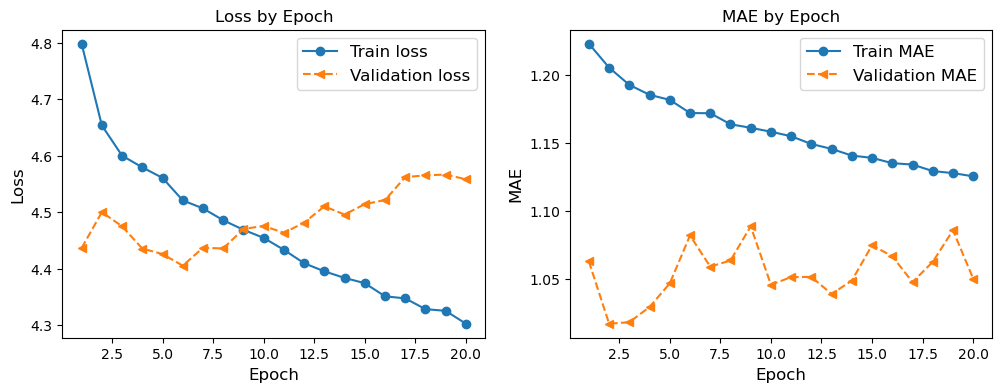

In [58]:
# Looking at learing curves for potential candidates
create_nn(contin_vars='yes', lagged_vars=3, epoch_count=20, learning_rate=0.001, hidden_layer_sizes=[50], 
          oput_act_func = 'relu', verbosity_flag=False)

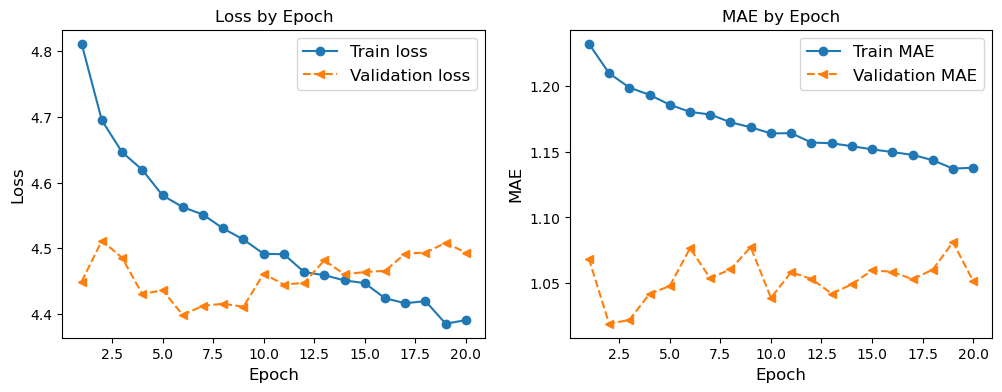

In [59]:
# Looking at learing curves for potential candidates
create_nn(contin_vars='yes', lagged_vars=3, epoch_count=20, learning_rate=0.001, hidden_layer_sizes=[37], 
          oput_act_func = 'relu', verbosity_flag=False)

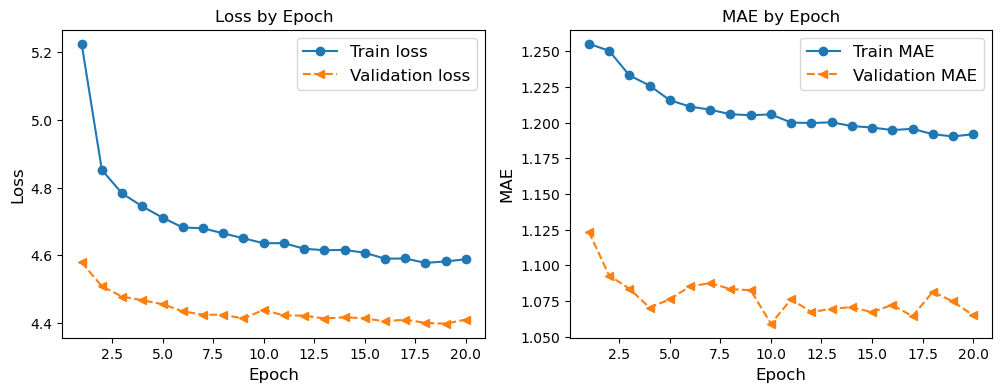

In [24]:
# Looking at learing curves for potential candidates
create_nn(contin_vars='yes', lagged_vars=3, epoch_count=20, learning_rate=0.0001, hidden_layer_sizes=[50], 
          oput_act_func = 'relu', verbosity_flag=False)

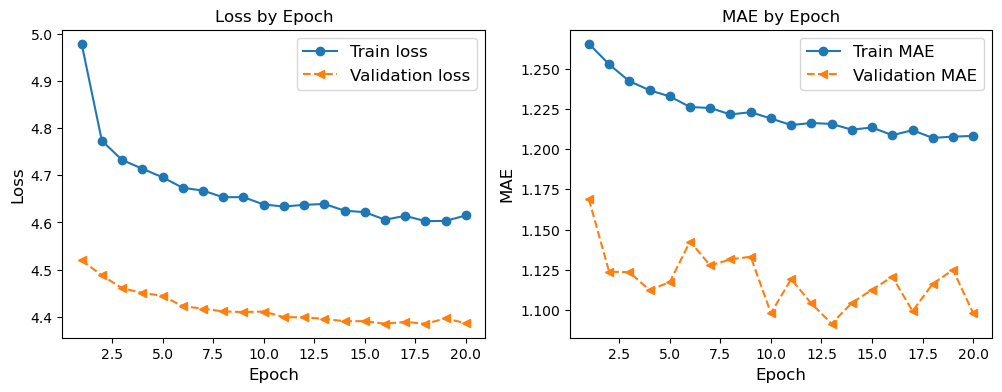

In [63]:
# Looking at learing curves for potential candidates
create_nn(contin_vars='yes', lagged_vars=3, epoch_count=20, learning_rate=0.001, hidden_layer_sizes=[50], 
          oput_act_func = 'relu', optimizer='SGD', verbosity_flag=False)

# Testing Various Configurations

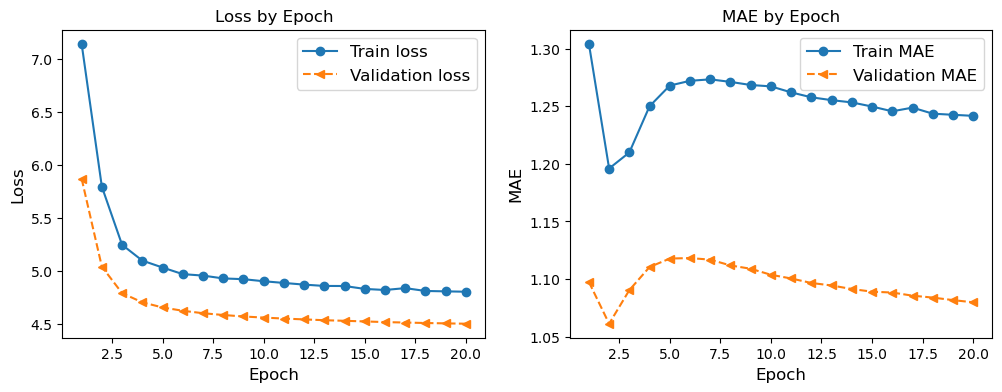

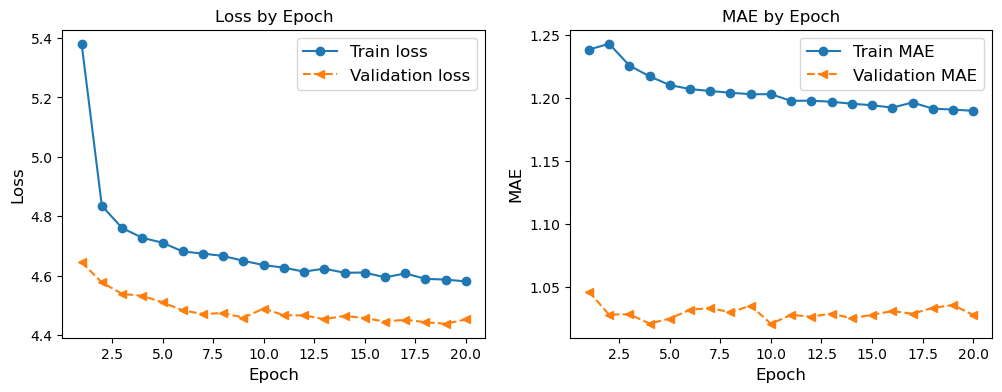

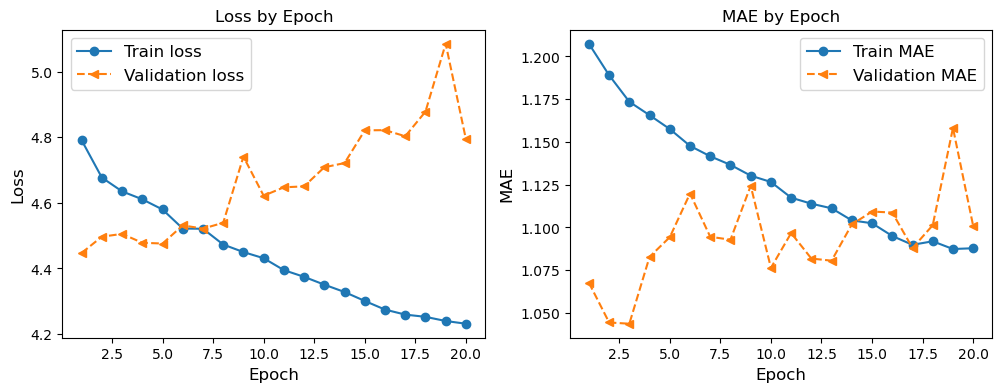

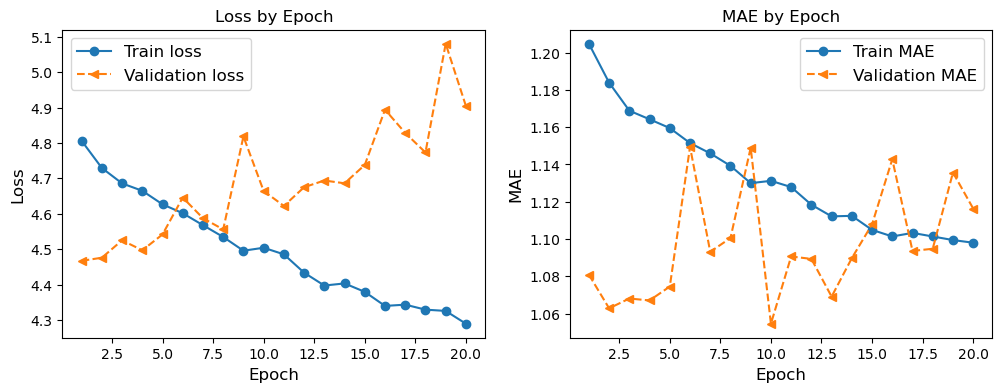

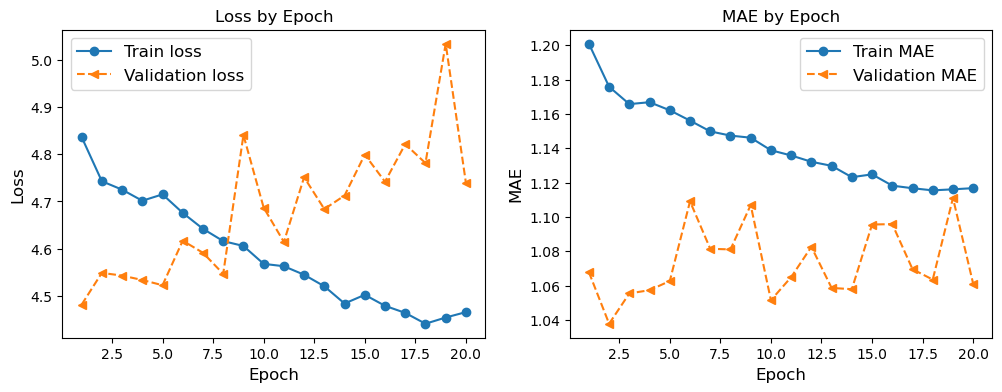

In [32]:
## Learning Rates

for rate in [0.00001, 0.0001, 0.005, 0.0075, 0.01]: # Learning rate(s)
    create_nn(contin_vars='yes', lagged_vars=3, epoch_count=20, learning_rate=rate, hidden_layer_sizes=[50], 
              oput_act_func = 'relu', verbosity_flag=False)

# Seems like 0.00001 and 0.0001 are best; I'm going to try both with more epochs

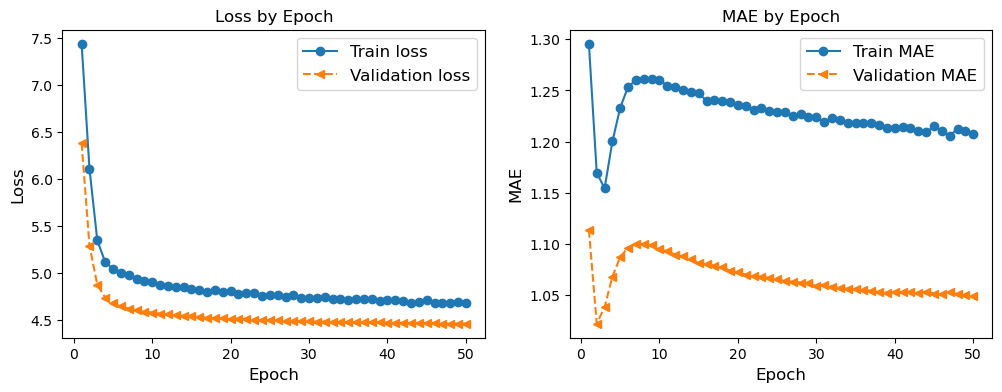

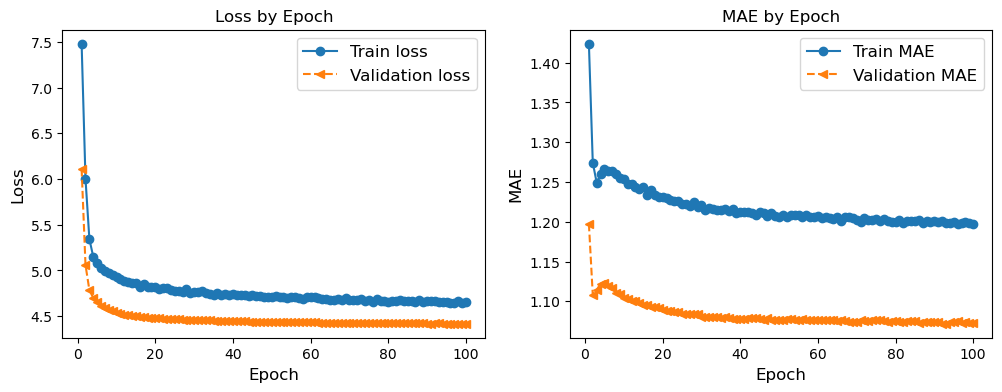

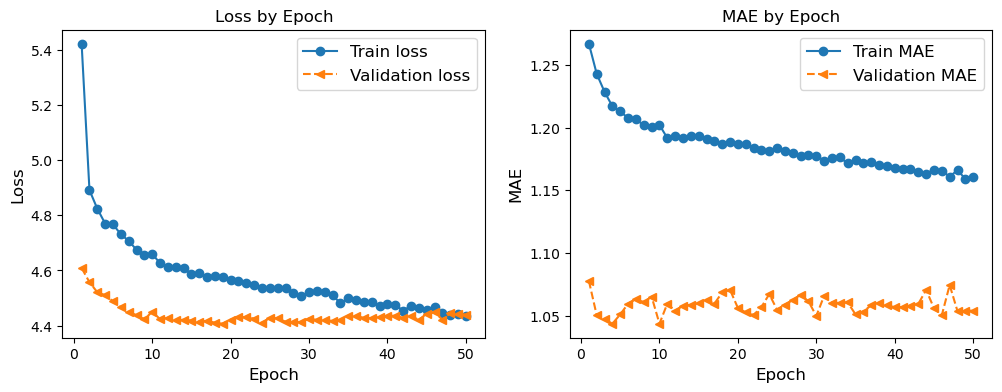

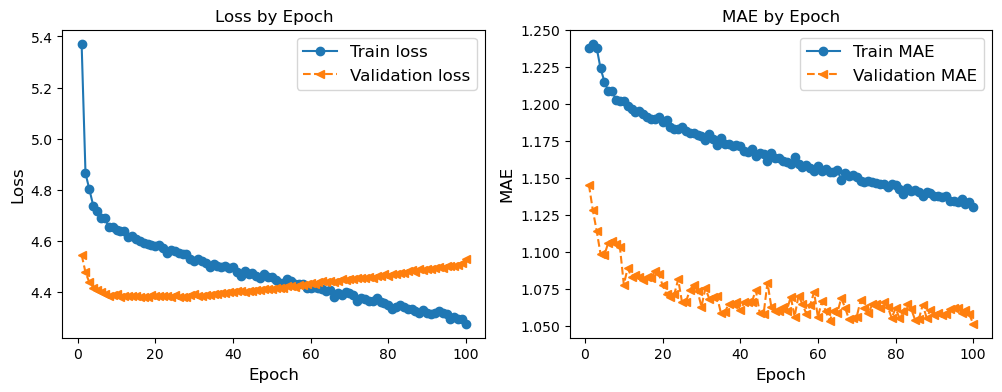

In [33]:
## Epochs

for rate in [0.00001, 0.0001]: # Learning rates
    for epochs in [50, 100]:   # Epoch counts
        create_nn(contin_vars='yes', lagged_vars=3, epoch_count=epochs, learning_rate=rate, hidden_layer_sizes=[50], 
                  oput_act_func = 'relu', verbosity_flag=False)

# Learning rate of 0.0001 and 50 epochs seems best, though it starts to overfit at the end

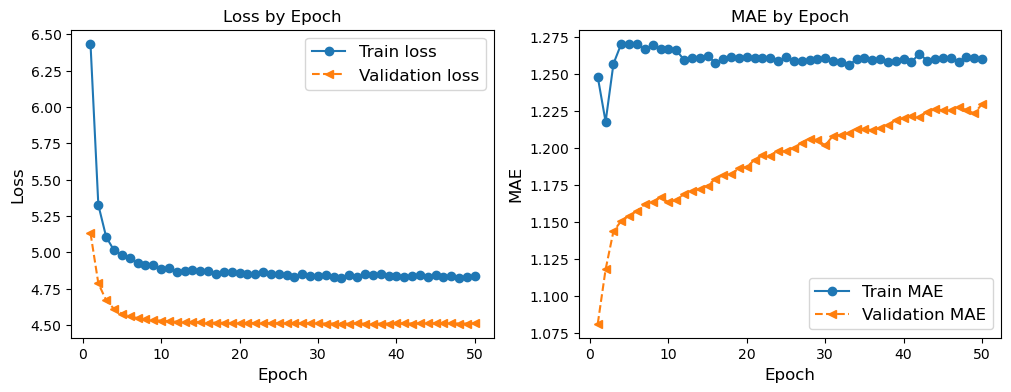

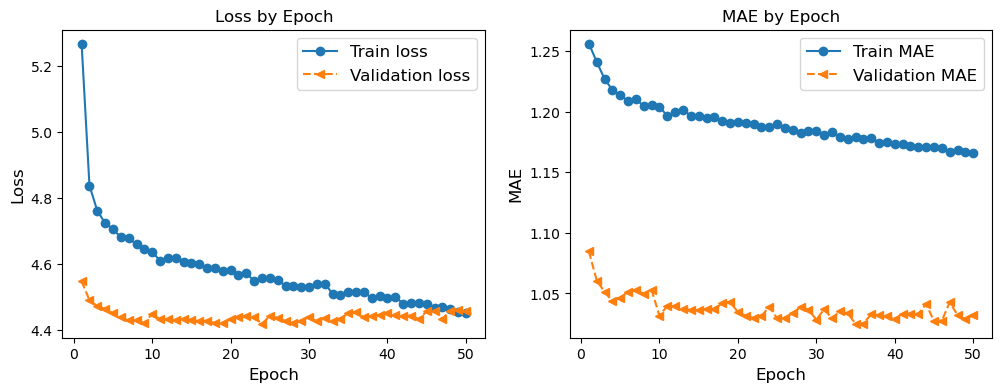

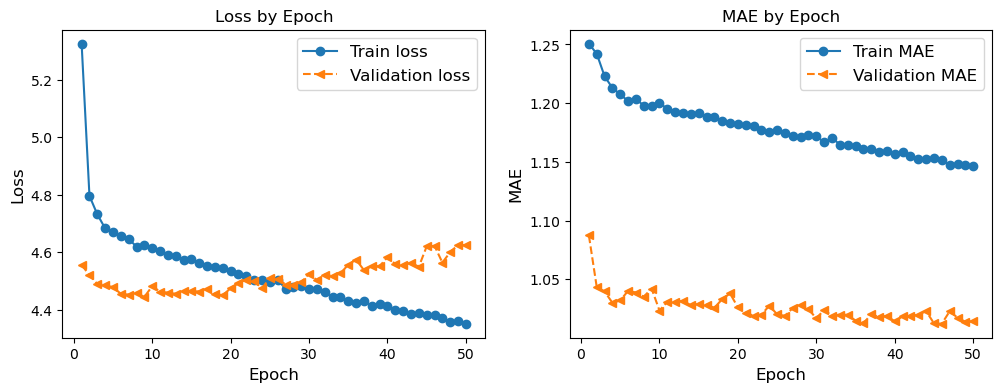

In [34]:
## Hidden layer sizes

for layers in [[], [50], [100]]: # Hidden layer sizes
    create_nn(contin_vars='yes', lagged_vars=3, epoch_count=50, learning_rate=0.0001, hidden_layer_sizes=layers, 
              oput_act_func = 'relu', verbosity_flag=False)

# One hidden layer with 50 is definitely the move

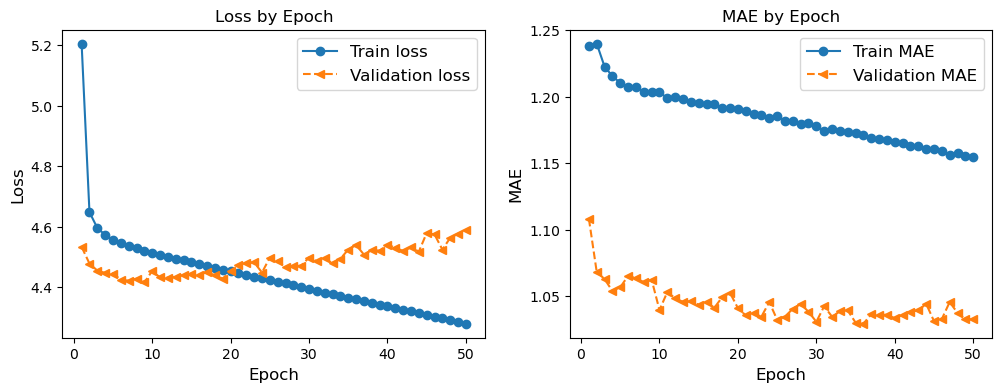

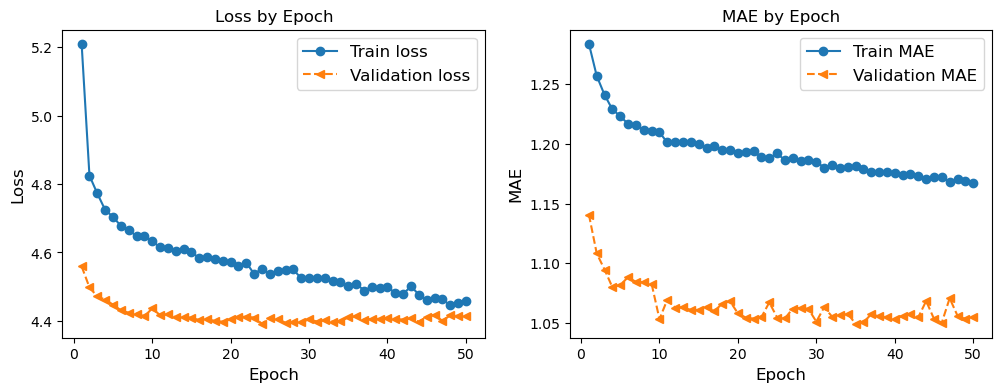

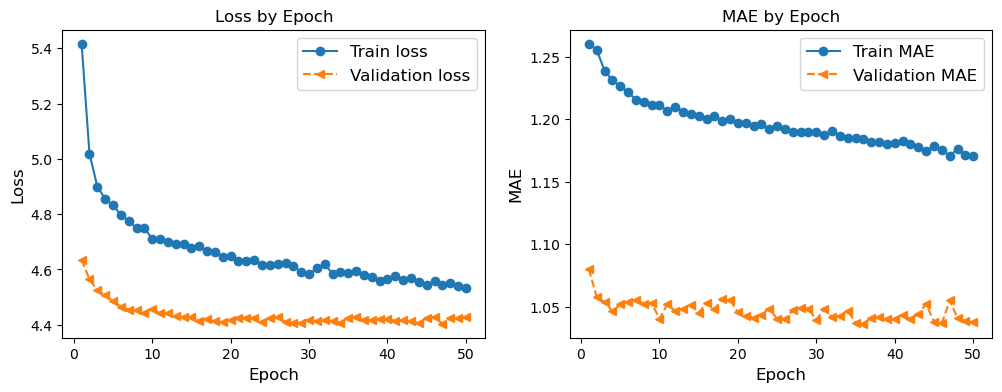

In [36]:
## Trying a lower learning rate with more dropout
for dropout in [0, 0.3, 0.5]:
    create_nn(contin_vars='yes', lagged_vars=3, epoch_count=50, learning_rate=0.0001, hidden_layer_sizes=[50], 
              dropout_rate=dropout, oput_act_func = 'relu', verbosity_flag=False)

# 0.3 dropout seems to be good enough, though loss isn't stabilizing - 
# it's possible that more epochs would be helpful (though we've seen from above that this will likely drive overfitting)

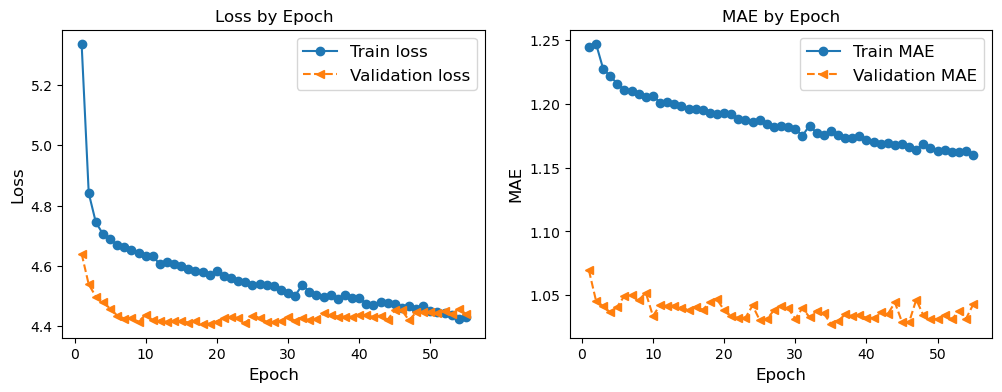

In [51]:
## Final selection so far

create_nn(contin_vars='yes', lagged_vars=3, epoch_count=55, learning_rate=0.0001, hidden_layer_sizes=[50], 
              dropout_rate=0.3, oput_act_func = 'relu', verbosity_flag=False)

# You do want a little bit of overfit - could possibly use a little more training
# Or using a learning rate schedule - there are libraries to do this - Iishaan will send potentially

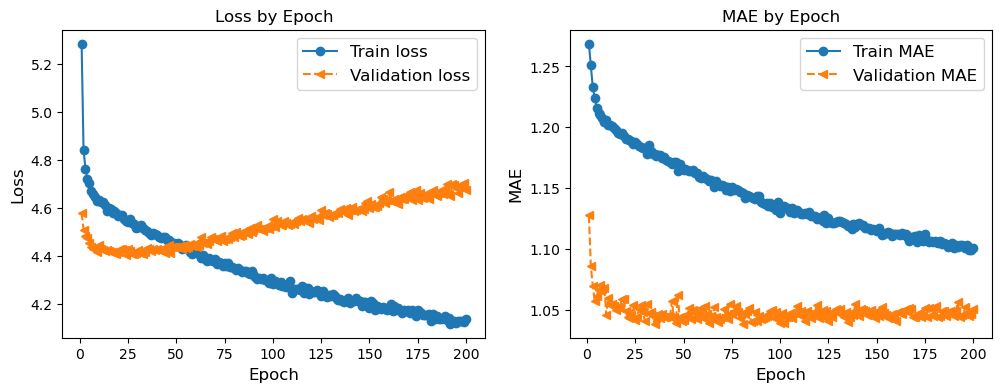

In [49]:
## Final selection so far

create_nn(contin_vars='yes', lagged_vars=3, epoch_count=200, learning_rate=0.0001, hidden_layer_sizes=[50], 
              dropout_rate=0.3, oput_act_func = 'relu', verbosity_flag=False)

# You do want a little bit of overfit - could possibly use a little more training
# Or using a learning rate schedule - there are libraries to do this - Iishaan will send potentially

In [50]:
results

,contin_vars,lagged_vars,learning_rate,epoch_count,hidden_layer_count,hidden_layer_size_s,hl_act_func,dropout_rate,oput_act_func,optimizer,train_loss,train_mae,val_loss,val_mae
0,yes,3,0.0001,50,1,[50],relu,0.3,relu,Adam,4.446300,1.168855,4.423523,1.051845
1,yes,3,0.0001,50,1,[50],relu,0.4,relu,Adam,4.513988,1.171249,4.414470,1.058176
2,yes,3,0.0001,75,1,[50],relu,0.3,relu,Adam,4.367848,1.147654,4.506692,1.049430
3,yes,3,0.0001,55,1,[50],relu,0.3,relu,Adam,4.442424,1.158825,4.461624,1.038363
4,yes,3,0.0001,200,1,[50],relu,0.3,relu,Adam,4.135762,1.100690,4.674696,1.051062


# Scaling Up Columns - Adding One at a Time

In [23]:
# Making a DF in which to store results
results_iter = pd.DataFrame(columns=['column_list', 'cat_tensor_count', 'learning_rate', 'epoch_count', 'hidden_layer_count',
                                    'hidden_layer_size_s','hl_act_func','dropout_rate','oput_act_func','optimizer',
                                    'train_loss', 'train_mae','val_loss','val_mae'])

In [24]:
X_train_contin3_tf = tf.convert_to_tensor(X_train[lag_3])
X_val_contin3_tf = tf.convert_to_tensor(X_val[lag_3])

train_cat_tf = [X_train_contin3_tf, season_train, player_team_name_train, opp_team_name_train, opp_diff_ind_train, 
                position_train, gw_train, was_home_train]
val_cat_tf = [X_val_contin3_tf, season_val, player_team_name_val, opp_team_name_val, opp_diff_ind_val, 
              position_val, gw_val, was_home_val]

In [25]:
# Setup for testing different configurations

def create_nn(column_list, cat_tensor_count=0, learning_rate=0.0001, epoch_count=50, hidden_layer_sizes=[50], 
              hl_act_func='relu', dropout_rate=0.3, oput_act_func='relu', optimizer='Adam', plot_flag=True,
              verbosity_flag=True):
    
    ############################################################################################## 1
    # Preparing the data

    tf.keras.backend.clear_session()

    if cat_tensor_count == 0:
        X_train_input = tf.convert_to_tensor(X_train[column_list])
        X_val_input = tf.convert_to_tensor(X_val[column_list])
    else:
        # Note: I don't know how to add tensors to a list. To get around this, if you run with categorical variables, this 
        # automatically uses all of the continuous variables
        X_train_input = tf.keras.layers.Concatenate(axis=1)(train_cat_tf[0:cat_tensor_count+1])
        X_val_input = tf.keras.layers.Concatenate(axis=1)(val_cat_tf[0:cat_tensor_count+1])

    # Getting number of features
    num_features = X_train_input.shape[1]

    ############################################################################################## 2
    # Building the model
    
    model = tf.keras.Sequential()

    # Create input layer
    model.add(tf.keras.Input(shape=(num_features,), name='Input'
              ))

    # (Optional) Create hidden layers
    for i, hidden_layer_size in enumerate(hidden_layer_sizes):
      model.add(tf.keras.layers.Dense(units=hidden_layer_size,
                                     activation=hl_act_func,
                                     name = f'Hidden_{i+1}'))

    # (Optional) Create dropout
    model.add(tf.keras.layers.Dropout(rate=dropout_rate, name='Dropout') # Need to make dropout rate variable
              )
    
    # Create output layer
    model.add(tf.keras.layers.Dense(
              activation = oput_act_func,    # linear activation is used
              units = 1,                # output dim - need to make sure this is correct
              use_bias = True             
              ))
    
    # Select optimizer
    if optimizer == 'SGD':
      opt = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    elif optimizer == 'Adam':
      opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    else:
      raise 'Unsupported optimizer: %s' %optimizer

    ############################################################################################## 3
    # Compiling the model
    model.compile(
        optimizer=opt,
        loss='mse',
        metrics=[metrics.mse,
                 metrics.RootMeanSquaredError(),
                 metrics.mae]
        )

    ############################################################################################## 4
    # Fitting the model
    history = model.fit(
        x = X_train_input,
        y = Y_train_tf,
        epochs = epoch_count,
        validation_data = (X_val_input, Y_val_tf),
        verbose=verbosity_flag
    )

    ############################################################################################## 5
    # Displaying learning rates
    if plot_flag == True:
        loss_mae_plots(history)

    ############################################################################################## 6
    # Appending results to the results DF

    # Pulling this in to get loss and accuracy
    hist = history.history
    
    new_row = {'column_list': column_list[-1], 'cat_tensor_count': cat_tensor_count, 'learning_rate': learning_rate, 
               'epoch_count': epoch_count, 'hidden_layer_count': len(hidden_layer_sizes), 'hidden_layer_size_s': hidden_layer_sizes,
               'hl_act_func': hl_act_func, 'dropout_rate':dropout_rate, 'oput_act_func': oput_act_func,'optimizer': optimizer, 
               'train_loss': hist['loss'][-1], 'train_mae': hist['mean_absolute_error'][-1], 'val_loss': hist['val_loss'][-1], 
               'val_mae': hist['val_mean_absolute_error'][-1]}
    
    results_iter.loc[len(results_iter)] = new_row

In [182]:
lag_3 = ['assists_lag_3', 'bonus_lag_3', 'bps_lag_3', 'clean_sheets_lag_3',
       'creativity_lag_3', 'goals_conceded_lag_3', 'goals_scored_lag_3',
       'ict_index_lag_3', 'influence_lag_3', 'minutes_lag_3',
       'own_goals_lag_3', 'penalties_missed_lag_3', 'penalties_saved_lag_3',
       'red_cards_lag_3', 'saves_lag_3', 'selected_lag_3',
       'player_team_score_lag_3', 'opp_team_score_lag_3', 'threat_lag_3',
       'total_points_lag_3', 'value_lag_3', 'yellow_cards_lag_3']

col_list = []

# Iterating up the continuous variable count by one each time
for i in range(0, len(lag_3)):
    col_list.append(lag_3[i])
    print(f'Used columns {col_list}')
    create_nn(column_list=col_list, cat_tensor_count=0, epoch_count=20, learning_rate=0.0001, hidden_layer_sizes=[50], 
              dropout_rate=0.3, oput_act_func = 'relu', verbosity_flag=False, plot_flag=False)

Used columns ['assists_lag_3']
Used columns ['assists_lag_3', 'bonus_lag_3']
Used columns ['assists_lag_3', 'bonus_lag_3', 'bps_lag_3']
Used columns ['assists_lag_3', 'bonus_lag_3', 'bps_lag_3', 'clean_sheets_lag_3']
Used columns ['assists_lag_3', 'bonus_lag_3', 'bps_lag_3', 'clean_sheets_lag_3', 'creativity_lag_3']
Used columns ['assists_lag_3', 'bonus_lag_3', 'bps_lag_3', 'clean_sheets_lag_3', 'creativity_lag_3', 'goals_conceded_lag_3']
Used columns ['assists_lag_3', 'bonus_lag_3', 'bps_lag_3', 'clean_sheets_lag_3', 'creativity_lag_3', 'goals_conceded_lag_3', 'goals_scored_lag_3']
Used columns ['assists_lag_3', 'bonus_lag_3', 'bps_lag_3', 'clean_sheets_lag_3', 'creativity_lag_3', 'goals_conceded_lag_3', 'goals_scored_lag_3', 'ict_index_lag_3']
Used columns ['assists_lag_3', 'bonus_lag_3', 'bps_lag_3', 'clean_sheets_lag_3', 'creativity_lag_3', 'goals_conceded_lag_3', 'goals_scored_lag_3', 'ict_index_lag_3', 'influence_lag_3']
Used columns ['assists_lag_3', 'bonus_lag_3', 'bps_lag_3', 

In [183]:
results_iter

,column_list,cat_tensor_count,learning_rate,epoch_count,hidden_layer_count,hidden_layer_size_s,hl_act_func,dropout_rate,oput_act_func,optimizer,train_loss,train_mae,val_loss,val_mae
0,assists_lag_3,0,0.0001,20,1,[50],relu,0.3,relu,Adam,6.070930,1.598627,5.763089,1.572530
1,bonus_lag_3,0,0.0001,20,1,[50],relu,0.3,relu,Adam,5.788173,1.531892,5.511933,1.497523
2,bps_lag_3,0,0.0001,20,1,[50],relu,0.3,relu,Adam,5.063041,1.308051,4.736710,1.236652
3,clean_sheets_lag_3,0,0.0001,20,1,[50],relu,0.3,relu,Adam,5.014562,1.299074,4.715441,1.233650
4,creativity_lag_3,0,0.0001,20,1,[50],relu,0.3,relu,Adam,4.973116,1.287658,4.664929,1.215381
5,goals_conceded_lag_3,0,0.0001,20,1,[50],relu,0.3,relu,Adam,4.959083,1.282245,4.658119,1.209772
6,goals_scored_lag_3,0,0.0001,20,1,[50],relu,0.3,relu,Adam,4.936039,1.278926,4.643783,1.206804
7,ict_index_lag_3,0,0.0001,20,1,[50],relu,0.3,relu,Adam,4.876334,1.272604,4.609080,1.205044
8,influence_lag_3,0,0.0001,20,1,[50],relu,0.3,relu,Adam,4.885963,1.273324,4.599294,1.203903
9,minutes_lag_3,0,0.0001,20,1,[50],relu,0.3,relu,Adam,4.849053,1.270104,4.572609,1.195696


Used 1 of the categorical variables
Used 2 of the categorical variables
Used 3 of the categorical variables
Used 4 of the categorical variables
Used 5 of the categorical variables
Used 6 of the categorical variables
Used 7 of the categorical variables


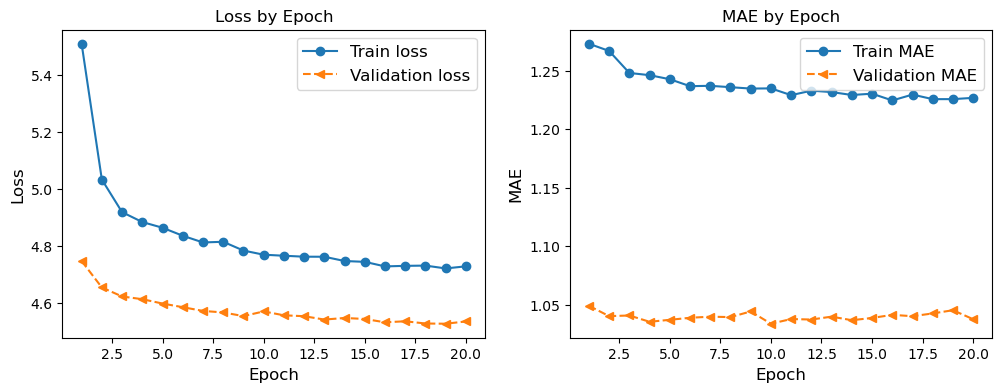

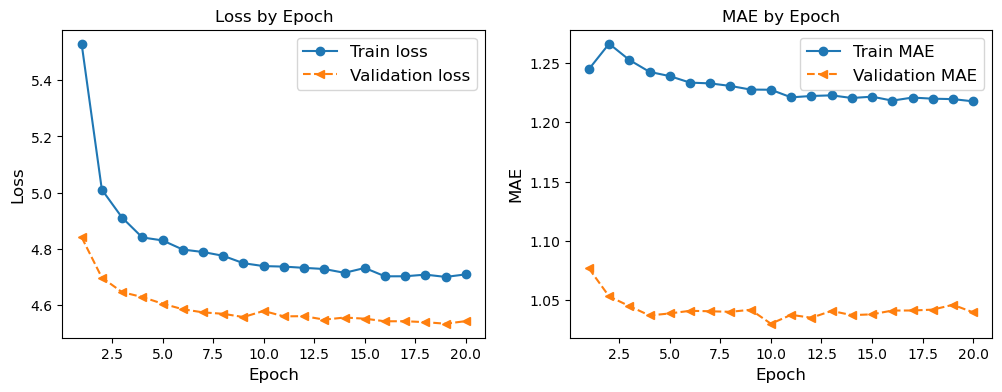

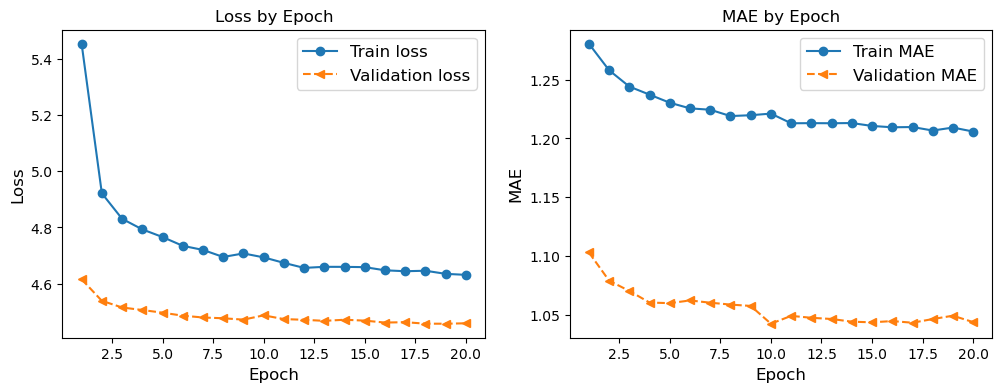

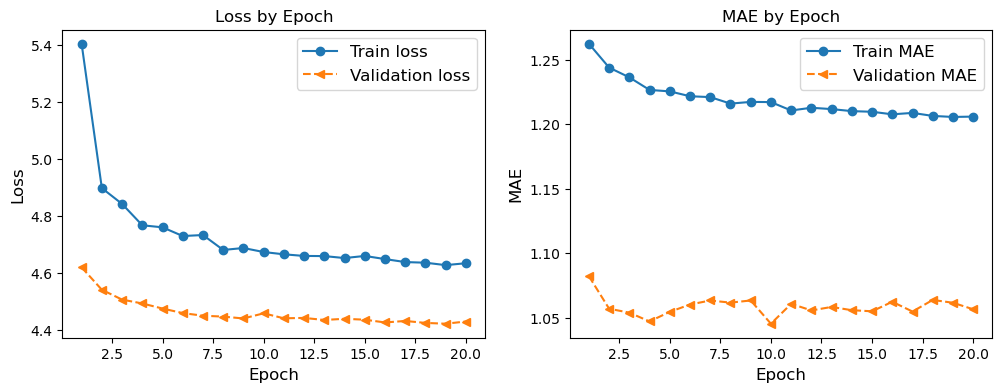

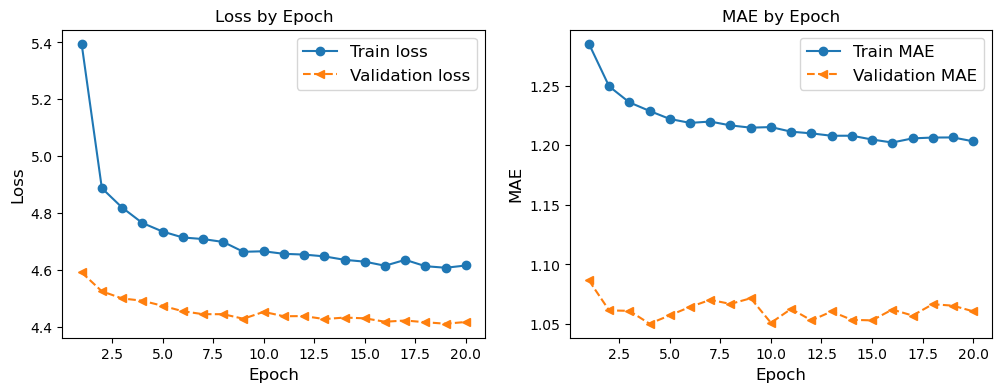

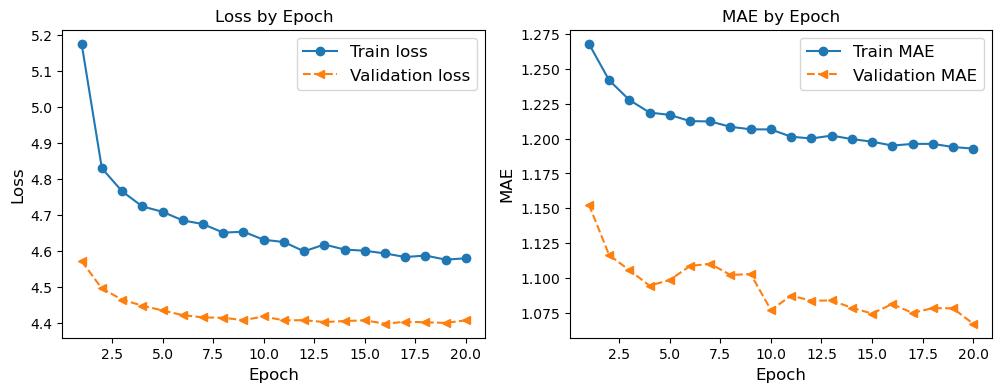

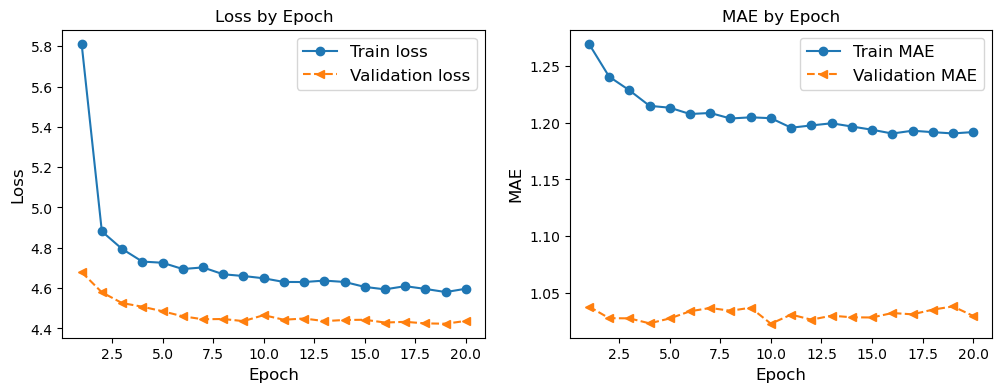

In [26]:
# Adding in categorical variables one at a time
for i in range(1, len(train_cat_tf)):
    print(f'Used {i} of the categorical variables')
    create_nn(column_list=lag_3, cat_tensor_count=i, epoch_count=20, learning_rate=0.0001, hidden_layer_sizes=[50], 
              dropout_rate=0.3, oput_act_func = 'relu', verbosity_flag=False)

In [27]:
results_iter

,column_list,cat_tensor_count,learning_rate,epoch_count,hidden_layer_count,hidden_layer_size_s,hl_act_func,dropout_rate,oput_act_func,optimizer,train_loss,train_mae,val_loss,val_mae
0,yellow_cards_lag_3,1,0.0001,20,1,[50],relu,0.3,relu,Adam,4.728968,1.226908,4.535948,1.037456
1,yellow_cards_lag_3,2,0.0001,20,1,[50],relu,0.3,relu,Adam,4.709079,1.217664,4.542673,1.039757
2,yellow_cards_lag_3,3,0.0001,20,1,[50],relu,0.3,relu,Adam,4.631063,1.205810,4.458591,1.043613
3,yellow_cards_lag_3,4,0.0001,20,1,[50],relu,0.3,relu,Adam,4.633940,1.205869,4.429628,1.056615
4,yellow_cards_lag_3,5,0.0001,20,1,[50],relu,0.3,relu,Adam,4.616125,1.203260,4.417572,1.060694
5,yellow_cards_lag_3,6,0.0001,20,1,[50],relu,0.3,relu,Adam,4.579869,1.192816,4.407753,1.067237
6,yellow_cards_lag_3,7,0.0001,20,1,[50],relu,0.3,relu,Adam,4.597015,1.191844,4.437368,1.029422


In [28]:
results_iter.to_csv('iterative_results_v4.csv', encoding='utf-8')

In [168]:
results_iter.sort_values(by=['val_loss'], ascending=True)

,column_list,cat_tensor_count,learning_rate,epoch_count,hidden_layer_count,hidden_layer_size_s,hl_act_func,dropout_rate,oput_act_func,optimizer,train_loss,train_mae,val_loss,val_mae
4,"[assists_lag_3, bonus_lag_3, bps_lag_3, clean_...",7,0.0001,20,1,[50],relu,0.3,relu,Adam,4.582489,1.190517,4.436962,1.034229
3,"[assists_lag_3, bonus_lag_3, bps_lag_3, clean_...",0,0.0001,20,1,[50],relu,0.3,relu,Adam,5.043901,1.304073,4.741415,1.237421
2,"[assists_lag_3, bonus_lag_3, bps_lag_3, clean_...",0,0.0001,20,1,[50],relu,0.3,relu,Adam,5.793436,1.531322,5.511711,1.496329
1,"[assists_lag_3, bonus_lag_3, bps_lag_3, clean_...",0,0.0001,20,1,[50],relu,0.3,relu,Adam,6.057024,1.599325,5.761721,1.575394


In [170]:
results_iter.shape

(4, 14)

In [169]:
results_iter.to_csv('iterative_results_v2.csv', encoding='utf-8')

# Adding L1 Regularization

In [147]:
# Making a DF in which to store results
results = pd.DataFrame(columns=['contin_vars', 'lagged_vars', 'learning_rate', 'epoch_count', 'hidden_layer_count',
                                'hidden_layer_size_s','hl_act_func','dropout_rate','oput_act_func', 'l1_reg',
                                'optimizer', 'train_loss', 'train_mae','val_loss','val_mae'])

In [151]:
# Setup for testing different configurations

def create_nn(contin_vars='yes', lagged_vars=3, learning_rate=0.01, epoch_count=5, hidden_layer_sizes=[], 
              hl_act_func='relu', dropout_rate=0.3, oput_act_func=None, regularizer='no',optimizer='Adam', plot_flag=True,
              verbosity_flag=True):
    
    ############################################################################################## 1
    # Preparing the data

    # Note: the user must at least either feed in 'yes' to contin_vars or 1, 3, or 5 to lagged_vars to avoid errors;
    # if a user passed 'no' and another number, the code will error out
    
    # Runs if user wants to include continuous variables
    if contin_vars == 'yes':
        train_list = train_cat_tf
        val_list = val_cat_tf

        if lagged_vars == 1:
            train_list = [season_train, player_team_name_train, opp_team_name_train, opp_diff_ind_train, 
                          position_train, gw_train, was_home_train, X_train_contin1_tf]
            val_list = [season_val, player_team_name_val, opp_team_name_val, opp_diff_ind_val, 
                        position_val, gw_val, was_home_val, X_val_contin1_tf]
        elif lagged_vars == 3:
            train_list = [season_train, player_team_name_train, opp_team_name_train, opp_diff_ind_train, 
                          position_train, gw_train, was_home_train, X_train_contin3_tf]
            val_list = [season_val, player_team_name_val, opp_team_name_val, opp_diff_ind_val, 
                        position_val, gw_val, was_home_val, X_val_contin3_tf]
        elif lagged_vars == 5:
            train_list = [season_train, player_team_name_train, opp_team_name_train, opp_diff_ind_train, 
                          position_train, gw_train, was_home_train, X_train_contin5_tf]
            val_list = [season_val, player_team_name_val, opp_team_name_val, opp_diff_ind_val, 
                        position_val, gw_val, was_home_val, X_val_contin5_tf]
        else:
            pass # Should do nothing
    
        X_train_input = tf.keras.layers.Concatenate(axis=1)(train_list)
        X_val_input = tf.keras.layers.Concatenate(axis=1)(val_list)

    # Runs if user does not want to include continuous variables
    elif contin_vars == 'no':
        if lagged_vars == 1:
            X_train_input = X_train_contin1_tf
            X_val_input = X_val_contin1_tf
        elif lagged_vars == 3:
            X_train_input = X_train_contin3_tf
            X_val_input = X_val_contin3_tf
        elif lagged_vars == 5:
            X_train_input = X_train_contin5_tf
            X_val_input = X_val_contin5_tf
        else:
            raise 'Unsupported lagged_var input: %s' %lagged_vars
    
    # Getting number of features
    num_features = X_train_input.shape[1]

    ############################################################################################## 2
    # Building the model
    tf.keras.backend.clear_session()
    model = tf.keras.Sequential()

    # Create input layer
    model.add(tf.keras.Input(shape=(num_features,), name='Input'
              ))

    # (Optional) Create hidden layers
    for i, hidden_layer_size in enumerate(hidden_layer_sizes):
      model.add(tf.keras.layers.Dense(units=hidden_layer_size,
                                     activation=hl_act_func,
                                     name = f'Hidden_{i+1}'))

    # (Optional) Create dropout
    model.add(tf.keras.layers.Dropout(rate=dropout_rate, name='Dropout') # Need to make dropout rate variable
              )

    # Create output layer
    if regularizer == 'yes':
        model.add(tf.keras.layers.Dense(
          activation = oput_act_func,    # linear activation is used
          units = 1,                # output dim - need to make sure this is correct
          use_bias = True,
          kernel_regularizer=tf.keras.regularizers.L1(l1=0.5) # L1 regularization
          ))
    else:
        model.add(tf.keras.layers.Dense(
          activation = oput_act_func,    # linear activation is used
          units = 1,                # output dim - need to make sure this is correct
          use_bias = True
          ))
    
    # Select optimizer
    if optimizer == 'SGD':
      opt = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    elif optimizer == 'Adam':
      opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    else:
      raise 'Unsupported optimizer: %s' %optimizer

    ############################################################################################## 3
    # Compiling the model
    model.compile(
        optimizer=opt,
        loss='mse',
        metrics=[metrics.mse,
                 metrics.RootMeanSquaredError(),
                 metrics.mae]
        )

    ############################################################################################## 4
    # Fitting the model
    history = model.fit(
        x = X_train_input,
        y = Y_train_tf,
        epochs = epoch_count,
        validation_data = (X_val_input, Y_val_tf),
        verbose=verbosity_flag
    )

    print(model.count_params())

    ############################################################################################## 5
    # Displaying learning rates
    if plot_flag == True:
        loss_mae_plots(history)

    ############################################################################################## 6
    # Appending results to the results DF

    # Pulling this in to get loss and accuracy
    hist = history.history
    
    new_row = {'contin_vars': contin_vars, 'lagged_vars': lagged_vars, 'learning_rate': learning_rate, 
               'epoch_count': epoch_count, 'hidden_layer_count': len(hidden_layer_sizes), 'hidden_layer_size_s': hidden_layer_sizes,
               'hl_act_func': hl_act_func, 'dropout_rate':dropout_rate, 'oput_act_func': oput_act_func,'optimizer': optimizer, 
               'l1_reg':regularizer, 'train_loss': hist['loss'][-1], 'train_mae': hist['mean_absolute_error'][-1], 
               'val_loss': hist['val_loss'][-1], 'val_mae': hist['val_mean_absolute_error'][-1]}
    
    results.loc[len(results)] = new_row

7251
7251


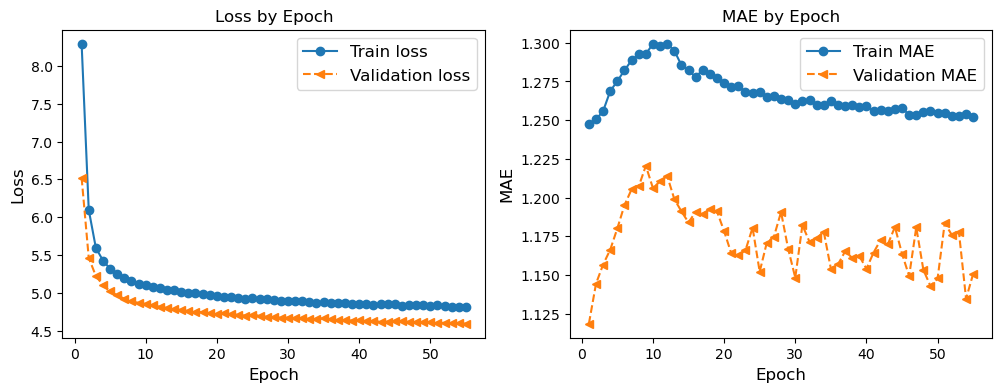

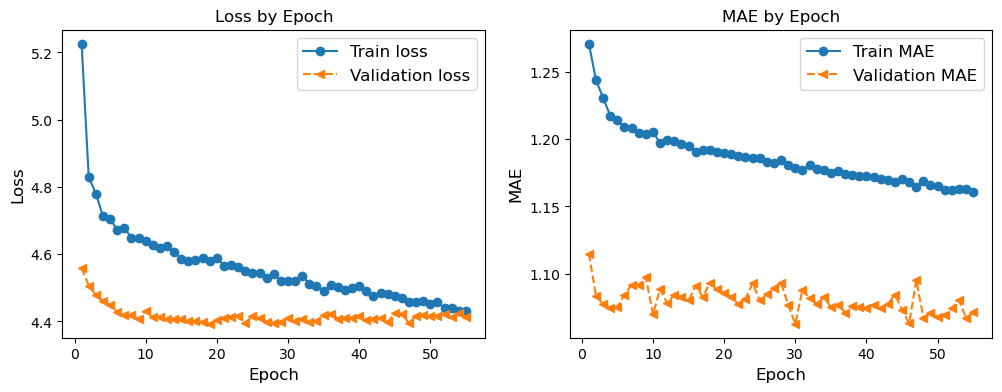

In [152]:
for reg in ['yes','no']:
    create_nn(contin_vars='yes', lagged_vars=3, epoch_count=55, learning_rate=0.0001, hidden_layer_sizes=[50], 
                  dropout_rate=0.3, oput_act_func = 'relu', regularizer=reg, verbosity_flag=False)

In [163]:
results_iter
# L1 does change the curve shape but doesn't help val loss

,column_list,cat_tensor_count,learning_rate,epoch_count,hidden_layer_count,hidden_layer_size_s,hl_act_func,dropout_rate,oput_act_func,optimizer,train_loss,train_mae,val_loss,val_mae
4,"[assists_lag_3, bonus_lag_3, bps_lag_3, clean_...",7,0.0001,20,1,[50],relu,0.3,relu,Adam,4.575526,1.189594,4.449402,1.024982


# Adding a learning rate scheduler

In [120]:
# Setup for testing different configurations

def create_nn(contin_vars='yes', lagged_vars=3, learning_rate=0.01, epoch_count=5, hidden_layer_sizes=[], 
              hl_act_func='relu', dropout_rate=0.3, oput_act_func=None, regularizer='no',optimizer='Adam', plot_flag=True,
              verbosity_flag=True):
    
    ############################################################################################## 1
    # Preparing the data

    # Note: the user must at least either feed in 'yes' to contin_vars or 1, 3, or 5 to lagged_vars to avoid errors;
    # if a user passed 'no' and another number, the code will error out
    
    # Runs if user wants to include continuous variables
    if contin_vars == 'yes':
        train_list = train_cat_tf
        val_list = val_cat_tf

        if lagged_vars == 1:
            train_list = [season_train, player_team_name_train, opp_team_name_train, opp_diff_ind_train, 
                          position_train, gw_train, was_home_train, X_train_contin1_tf]
            val_list = [season_val, player_team_name_val, opp_team_name_val, opp_diff_ind_val, 
                        position_val, gw_val, was_home_val, X_val_contin1_tf]
        elif lagged_vars == 3:
            train_list = [season_train, player_team_name_train, opp_team_name_train, opp_diff_ind_train, 
                          position_train, gw_train, was_home_train, X_train_contin3_tf]
            val_list = [season_val, player_team_name_val, opp_team_name_val, opp_diff_ind_val, 
                        position_val, gw_val, was_home_val, X_val_contin3_tf]
        elif lagged_vars == 5:
            train_list = [season_train, player_team_name_train, opp_team_name_train, opp_diff_ind_train, 
                          position_train, gw_train, was_home_train, X_train_contin5_tf]
            val_list = [season_val, player_team_name_val, opp_team_name_val, opp_diff_ind_val, 
                        position_val, gw_val, was_home_val, X_val_contin5_tf]
        else:
            pass # Should do nothing
    
        X_train_input = tf.keras.layers.Concatenate(axis=1)(train_list)
        X_val_input = tf.keras.layers.Concatenate(axis=1)(val_list)

    # Runs if user does not want to include continuous variables
    elif contin_vars == 'no':
        if lagged_vars == 1:
            X_train_input = X_train_contin1_tf
            X_val_input = X_val_contin1_tf
        elif lagged_vars == 3:
            X_train_input = X_train_contin3_tf
            X_val_input = X_val_contin3_tf
        elif lagged_vars == 5:
            X_train_input = X_train_contin5_tf
            X_val_input = X_val_contin5_tf
        else:
            raise 'Unsupported lagged_var input: %s' %lagged_vars
    
    # Getting number of features
    num_features = X_train_input.shape[1]

    ############################################################################################## 2
    # Building the model
    tf.keras.backend.clear_session()
    model = tf.keras.Sequential()

    # Create input layer
    model.add(tf.keras.Input(shape=(num_features,), name='Input'
              ))

    # (Optional) Create hidden layers
    for i, hidden_layer_size in enumerate(hidden_layer_sizes):
      model.add(tf.keras.layers.Dense(units=hidden_layer_size,
                                     activation=hl_act_func,
                                     name = f'Hidden_{i+1}'))

    # (Optional) Create dropout
    model.add(tf.keras.layers.Dropout(rate=dropout_rate, name='Dropout') # Need to make dropout rate variable
              )

    # Create output layer
    if regularizer == 'yes':
        model.add(tf.keras.layers.Dense(
          activation = oput_act_func,    # linear activation is used
          units = 1,                # output dim - need to make sure this is correct
          use_bias = True,
          kernel_regularizer=tf.keras.regularizers.L1() # L1 regularization
          ))
    else:
        model.add(tf.keras.layers.Dense(
          activation = oput_act_func,    # linear activation is used
          units = 1,                # output dim - need to make sure this is correct
          use_bias = True
          ))

    # Set a learning rate scheduler
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=learning_rate,
        decay_steps=100000,
        decay_rate=0.8)
    
    # Select optimizer
    if optimizer == 'SGD':
      opt = tf.keras.optimizers.SGD(learning_rate=lr_schedule)
    elif optimizer == 'Adam':
      opt = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
    else:
      raise 'Unsupported optimizer: %s' %optimizer

    ############################################################################################## 3
    # Compiling the model
    model.compile(
        optimizer=opt,
        loss='mse',
        metrics=[metrics.mse,
                 metrics.RootMeanSquaredError(),
                 metrics.mae]
        )

    ############################################################################################## 4
    # Fitting the model
    history = model.fit(
        x = X_train_input,
        y = Y_train_tf,
        epochs = epoch_count,
        validation_data = (X_val_input, Y_val_tf),
        verbose=verbosity_flag
    )

    ############################################################################################## 5
    # Displaying learning rates
    if plot_flag == True:
        loss_mae_plots(history)

    ############################################################################################## 6
    # Appending results to the results DF

    # Pulling this in to get loss and accuracy
    hist = history.history
    
    new_row = {'contin_vars': contin_vars, 'lagged_vars': lagged_vars, 'learning_rate': learning_rate, 
               'epoch_count': epoch_count, 'hidden_layer_count': len(hidden_layer_sizes), 'hidden_layer_size_s': hidden_layer_sizes,
               'hl_act_func': hl_act_func, 'dropout_rate':dropout_rate, 'oput_act_func': oput_act_func,'optimizer': optimizer, 
               'l1_reg':regularizer, 'train_loss': hist['loss'][-1], 'train_mae': hist['mean_absolute_error'][-1], 
               'val_loss': hist['val_loss'][-1], 'val_mae': hist['val_mean_absolute_error'][-1]}
    
    results.loc[len(results)] = new_row

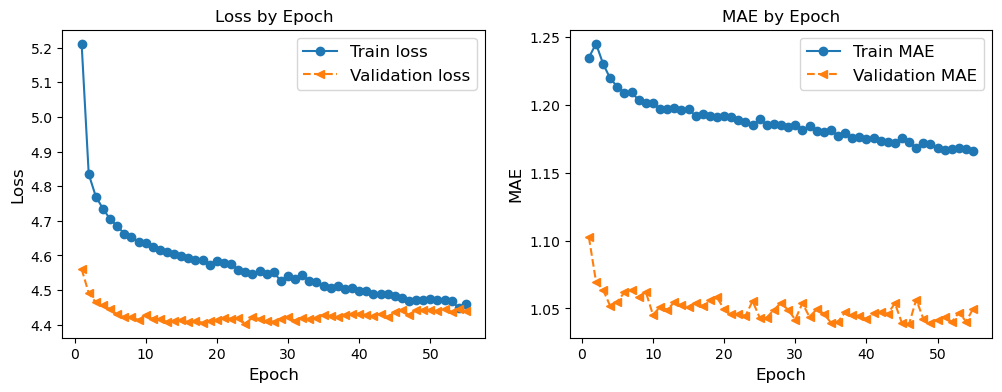

In [121]:
create_nn(contin_vars='yes', lagged_vars=3, epoch_count=55, learning_rate=0.0001, hidden_layer_sizes=[50], 
                  dropout_rate=0.3, oput_act_func = 'relu', verbosity_flag=False)

In [122]:
results
# I'm trying various steps (increasing from 10,000 by adding 0s) and decay rates (decreased from 0.9 to 0.8) to see if
# it does anything

# So far, none have beaten my "constant learning rate" models

,contin_vars,lagged_vars,learning_rate,epoch_count,hidden_layer_count,hidden_layer_size_s,hl_act_func,dropout_rate,oput_act_func,l1_reg,optimizer,train_loss,train_mae,val_loss,val_mae
0,yes,3,0.0001,55,1,[50],relu,0.3,relu,yes,Adam,4.567923,1.187471,4.436191,1.084265
1,yes,3,0.0001,55,1,[50],relu,0.3,relu,no,Adam,4.436679,1.164921,4.469140,1.034189
2,yes,3,0.0001,55,1,[50],relu,0.3,relu,no,Adam,4.504735,1.174352,4.424556,1.041045
3,yes,3,0.0001,55,1,[50],relu,0.3,relu,no,Adam,4.715248,1.215222,4.510962,1.031743
4,yes,3,0.0001,55,1,[50],relu,0.3,relu,no,Adam,4.442524,1.167451,4.418198,1.058056
5,yes,3,0.0001,55,1,[50],relu,0.3,relu,no,Adam,4.459182,1.166390,4.440116,1.049898


In [ ]:
# Things to try

# Look at which teams and positions drive the biggest loss
# Pull number of parameters to consider regularization vs not

# Hyperparameter tune within the learning rate scheduler
# Hyperparameter tune within L1 regularization
# Optuna for hypoerparameter tuning

In [154]:
ls = ['assists_lag_3', 'bonus_lag_3', 'bps_lag_3', 'clean_sheets_lag_3',
       'creativity_lag_3', 'goals_conceded_lag_3', 'goals_scored_lag_3',
       'ict_index_lag_3', 'influence_lag_3', 'minutes_lag_3',
       'own_goals_lag_3', 'penalties_missed_lag_3', 'penalties_saved_lag_3',
       'red_cards_lag_3', 'saves_lag_3', 'selected_lag_3',
       'player_team_score_lag_3', 'opp_team_score_lag_3', 'threat_lag_3',
       'total_points_lag_3', 'value_lag_3', 'yellow_cards_lag_3']

In [155]:
for i in ls:
    print(i)

assists_lag_3
bonus_lag_3
bps_lag_3
clean_sheets_lag_3
creativity_lag_3
goals_conceded_lag_3
goals_scored_lag_3
ict_index_lag_3
influence_lag_3
minutes_lag_3
own_goals_lag_3
penalties_missed_lag_3
penalties_saved_lag_3
red_cards_lag_3
saves_lag_3
selected_lag_3
player_team_score_lag_3
opp_team_score_lag_3
threat_lag_3
total_points_lag_3
value_lag_3
yellow_cards_lag_3
